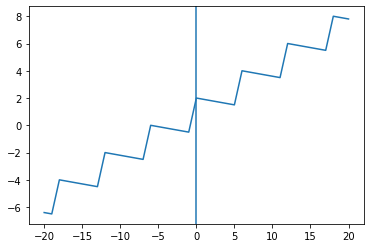

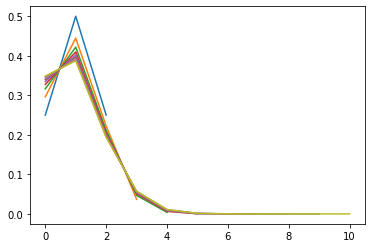

In [21]:
from random import random, choices, randint
from collections import Counter
from scipy.stats import binom
from statistics import mean,stdev, variance
import matplotlib.pyplot as plt
from numpy import sqrt, isclose
from copy import deepcopy
#org and genome classes

class Genome:
    def __init__(self,sites,genomeLength):
        if sites is None:
            self.sites = self.initSites(genomeLength)
            self.length = genomeLength
        else:
            self.sites = sites
            self.length = len(sites)
          
        
    def initSites(self,genomeLength):
        # all zeroes; good for sawtooth or max-1
        return [0 for _ in range(genomeLength)]

    
    
class Organism:
    def __init__(self,genome,genomeLength):
        if genome is None:
            self.genome = Genome(None,genomeLength)
        else:
            self.genome = genome
        self.offspringCount = 0
        self.fitness = None
            
    
    def makeMutatedCopy(self,):
        global MU
        self.offspringCount += 1
        
        newOrganism = Organism(deepcopy(self.genome),self.genome.length)
        for i in range(newOrganism.genome.length):
            if random() <= MU:
                sign = 1 if random() <= 0.5 else -1
                newOrganism.genome.sites[i] += sign
        return newOrganism
    
    
    def getFitness(self,evalFunc):
        if self.fitness is None:
            self.fitness = evalFunc(self)
        return self.fitness
    
#fitness function and selection algorithms
def sawtooth(organism,plot=False):
    w = 5 #valley width
    d = 0.5 #valley depth
    r = 2 #fitness rise peak to peak
    
    if plot:
        anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
        plt.plot(list(range(-20,21)),[anon(v+w+1) for v in range(-20,21)])
        plt.axvline(0)
        plt.show()
        return
    
    x = sum(organism.genome.sites)
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w))

sawtooth(None,plot=True)

def constFitness(organism):
    return 1

def linearFitness(organism):
    x = sum(organism.genome.sites)
#     return (2/5)*x
    return x

def tournament(population,size=2):
    global EVAL_FUNC
    return max(choices(population,k=size),key=lambda org: org.getFitness(EVAL_FUNC))

def onePeak(organism):
    x = sum(organism.genome.sites)
#     return -(x**2)
#     return 2*x if x < 0 else -0.5*x
    return -abs(x)

#selection strength components
DR = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

for testPopSize in [2,3,4,5,6,7,8,9,10]:
    plt.plot(getDriftReference(testPopSize,testPopSize)[:15])
# plt.yscale("log")
plt.show()

# MDR = {}
def moranDriftReference(N,maxOffCount):
#     if N not in MDR:
    z = (N-1)/(2*N-1)
    gtr1 = lambda n: (N/(N-1))**2 * (z)**(n+1)
#         MDR[N] = [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    return [z if n==0 else gtr1(n) for n in range(max(N,maxOffCount)+1)] # MDR[N]


def emd(P,Q):
    assert len(P) == len(Q)
#     plt.plot(P)
#     plt.plot(Q)
#     plt.xscale("symlog")
#     plt.yscale("symlog")
#     plt.show()
    
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


def getSS(offCounts_1d):#,initialPop,finalPop):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
#     print(N_init,N_final)
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(N_final+1)]
#     print("SUM",sum(Observed),Counts)
    assert isclose(sum(Observed),1)
    return emd(getDriftReference(N_init,N_final),Observed)


def getSSMoran(offCounts_1d,N):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/N if x in Counts else 0 for x in range(max(N,max(Counts.keys()))+1)]
#     print("cnt",Counts)
#     print("obs",Observed)
#     print("ref",moranDriftReference(N,max(Counts.keys())))
    return emd(moranDriftReference(N,max(Counts.keys())),Observed)


def dictionaryReduce(listOfDict,target={}):
    for dic in listOfDict:
        for key in set(list(dic.keys())+list(target.keys())):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

In [28]:
#parameters

POP_SIZE = 10000
GENOME_LENGTH = 1
MU = 1.0/(POP_SIZE/10)
GENERATIONS = 50
TSIZE = 3

EVAL_FUNC = sawtooth
# EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness

import numpy as np
def absExp(x):
    return np.exp(abs(np.log(x)))

9999 9998


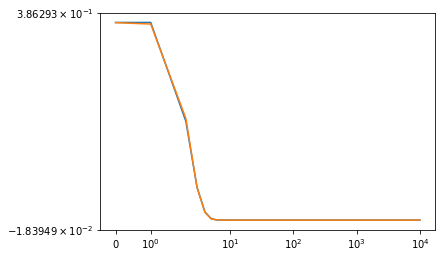

1 2


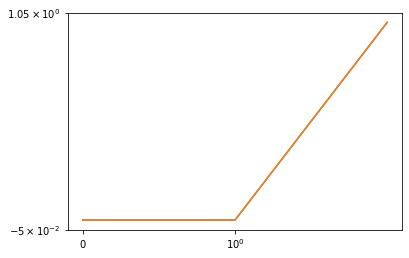

10000 10000


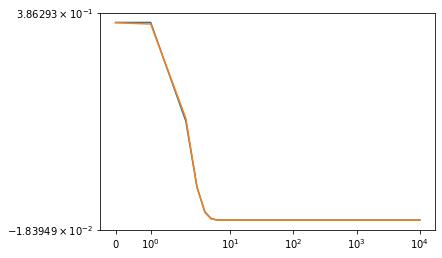

9998 9994


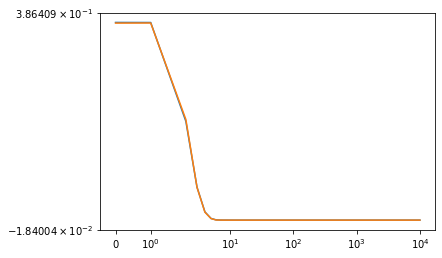

2 6


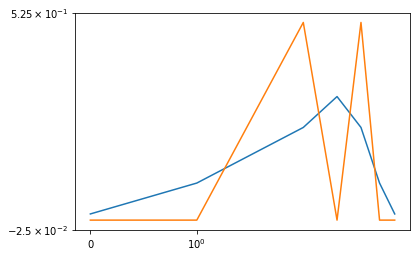

10000 10000


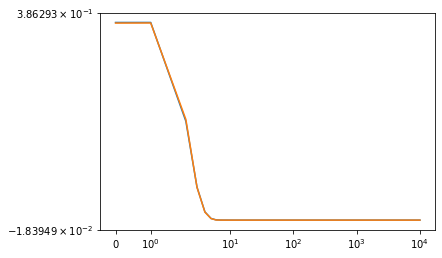

9994 9991


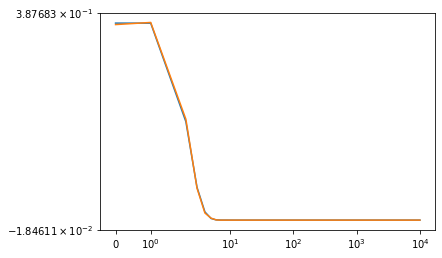

6 9


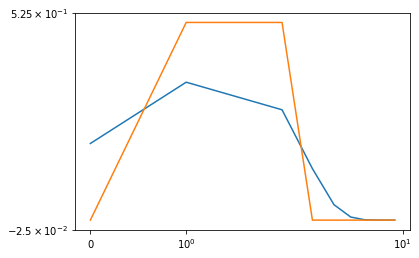

10000 10000


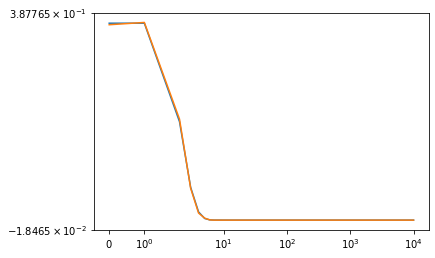

9991 9971


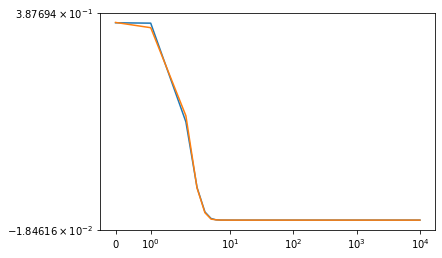

9 29


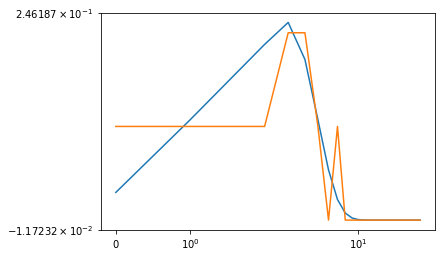

10000 10000


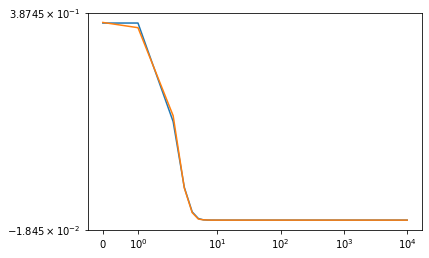

9971 9928


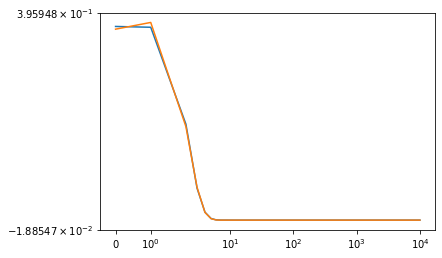

29 72


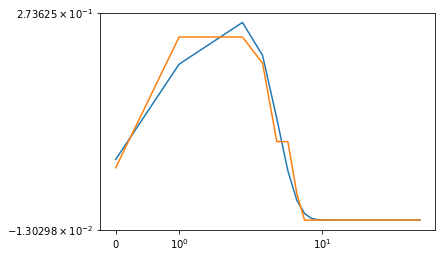

10000 10000


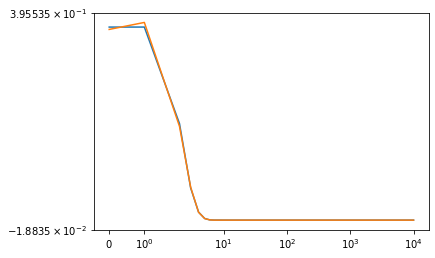

9928 9804


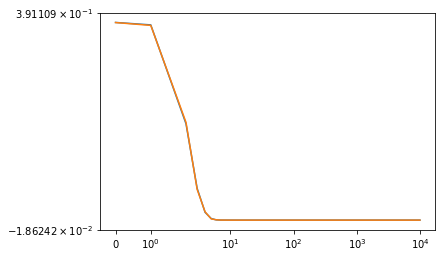

72 196


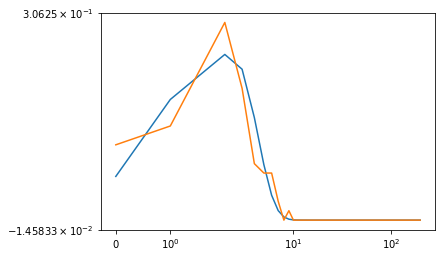

10000 10000


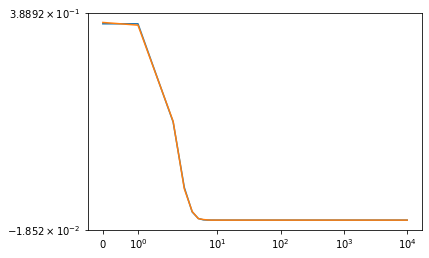

9804 9460


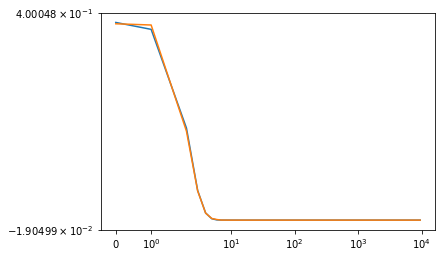

196 540


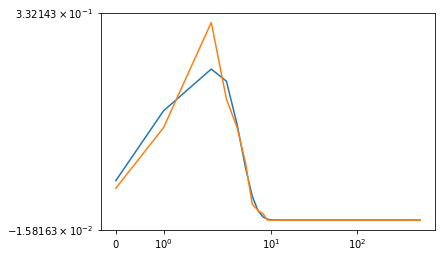

10000 10000


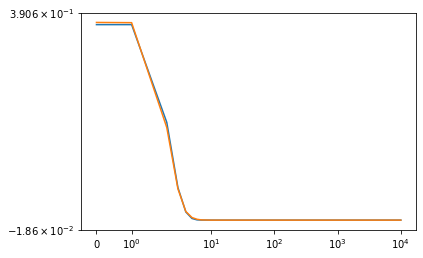

9460 8524


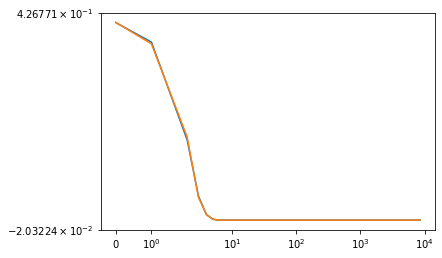

540 1476


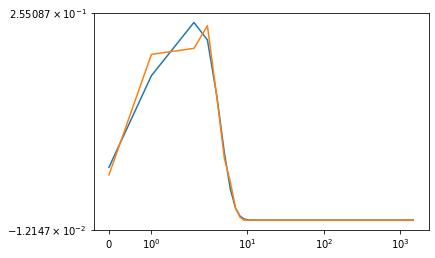

10000 10000


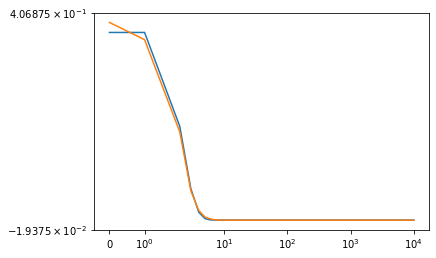

8524 6232


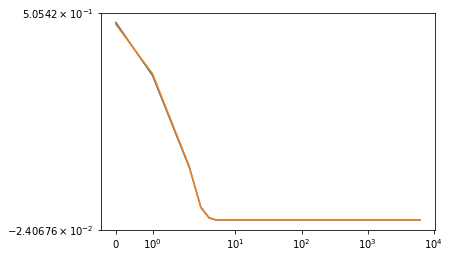

1476 3768


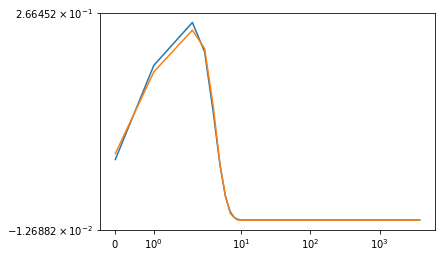

10000 10000


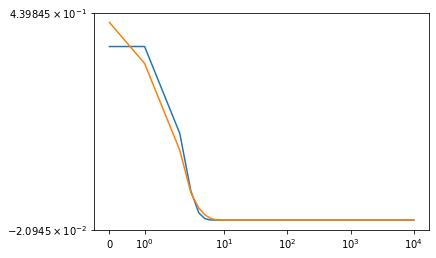

6232 2407


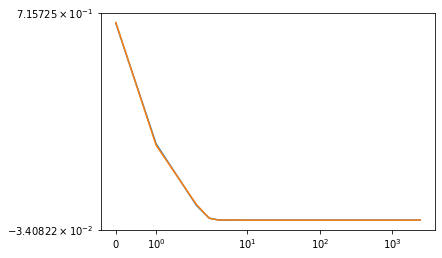

3768 7593


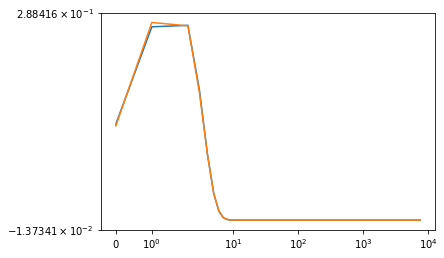

10000 10000


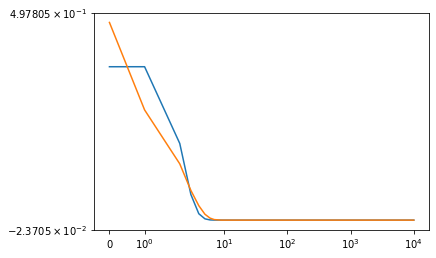

2407 151


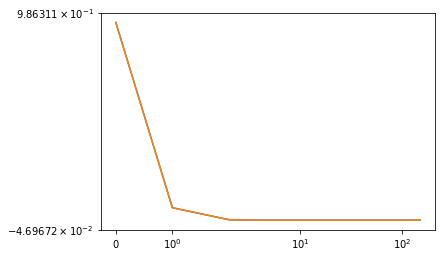

7593 9849


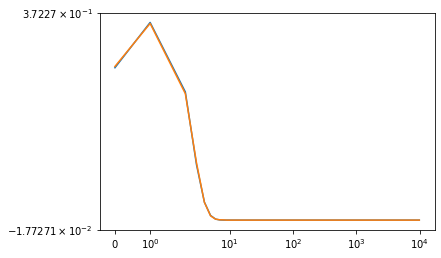

10000 10000


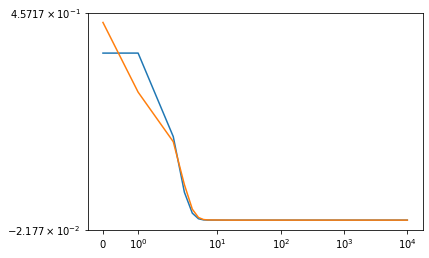

151 0


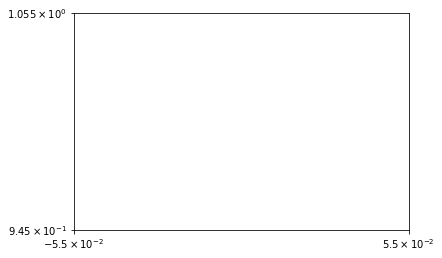

9849 10000


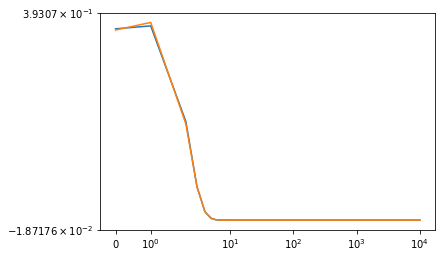

10000 10000


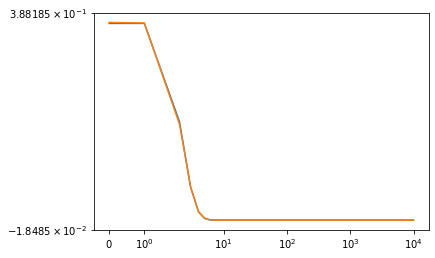

In [220]:
# no mutation test

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE-1)]
population.append(Organism(Genome([1 for _ in range(GENOME_LENGTH)],GENOME_LENGTH),GENOME_LENGTH))
dataLog = [[],[],[]]
offCountAcc = {}

for generation in range(GENERATIONS):
#     print(100*generation/GENERATIONS,"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    
    newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    
    for i in range(2):
        offspringCounts = Counter([org.offspringCount for org in population if org.genome.sites[0] == i])
        subpopsize = sum(offspringCounts.values())
        if subpopsize == 0:break
    #     offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
        if generation == 0:
            if i == 0:
                oldpopsize = POP_SIZE-1
            else:
                oldpopsize = 1
        else:
            oldpopsize = dataLog[i][generation-1][2]
            
        selectionStrength = getSS(offspringCounts)
        dataLog[i].append((aveFitness,selectionStrength,subpopsize))
        
    if subpopsize == 0:break
    offspringCounts = Counter([org.offspringCount for org in population])    
    selectionStrength = getSS(offspringCounts)
    dataLog[2].append(selectionStrength)
    
    population = newPopulation
print()

aveFitLog0, selStrLog0 ,popsizes0= list(zip(*dataLog[0]))
aveFitLog1, selStrLog1 ,popsizes1= list(zip(*dataLog[1]))
globalss = dataLog[2]

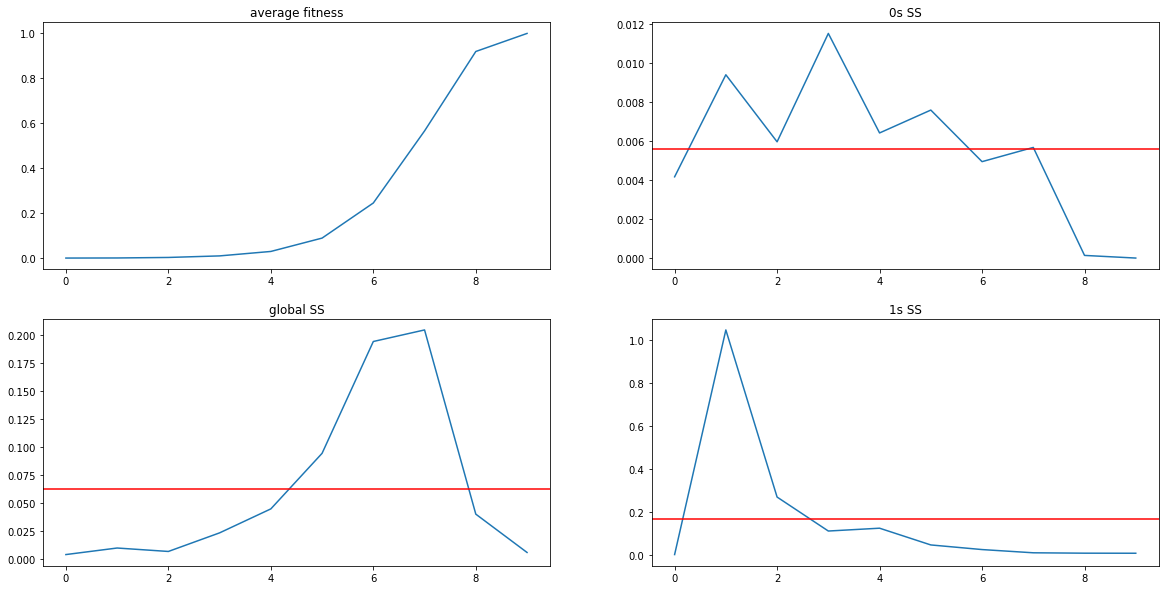

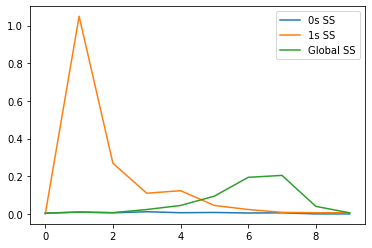

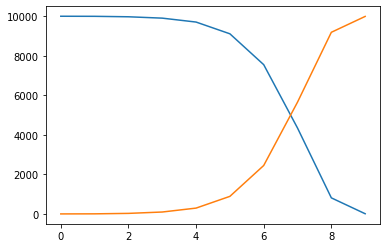

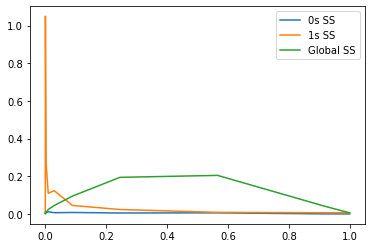

In [216]:
#plot WF results
fig, axs = plt.subplots(2,2,figsize=(20,10))

axs[0][0].plot(aveFitLog0)
axs[0][0].set_title("average fitness")
axs[0][1].plot(selStrLog0)
# print(mean(selStrLog0),stdev(selStrLog0))
axs[0][1].axhline(mean(selStrLog0),color="r")
axs[0][1].set_title("0s SS")


axs[1][0].plot(globalss)
axs[1][0].set_title("global SS")
axs[1][0].axhline(mean(globalss),color="r")

axs[1][1].plot(selStrLog1)
# print(mean(selStrLog1),stdev(selStrLog1))
axs[1][1].axhline(mean(selStrLog1),color="r")
axs[1][1].set_title("1s SS")
plt.show()

plt.plot(selStrLog0,label="0s SS")
plt.plot(selStrLog1,label="1s SS")
plt.plot(globalss,label="Global SS")
# plt.axhline(1)
plt.legend()
# plt.yscale("log")
plt.show()

plt.plot(popsizes0)
plt.plot(popsizes1)
plt.show()

plt.plot(aveFitLog0,selStrLog0,label="0s SS")
plt.plot(aveFitLog0,selStrLog1,label="1s SS")
plt.plot(aveFitLog0,globalss,label="Global SS")
# plt.yscale("log")
plt.legend()
plt.show()
# print("checkSum (1.0)", sum([sum(V) for V in offCountAcc.values()]) / (GENERATIONS*POP_SIZE) )
# meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
# stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

# plt.figure(figsize=(10,5))
# plt.plot(getDriftReference(POP_SIZE,POP_SIZE)[:max(offCountAcc.keys())+1],
#          label="Wright-Fisher Drift Theory",color="k")

# plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

# plt.fill_between(sorted(stdvDict.keys()),
#                  [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  alpha=0.3,color="r",label="99% Confidence interval")
# plt.legend()
# plt.title("")
# plt.xlabel("Parent's Offspring Count")
# plt.ylabel("Fraction of Parents with Count")
# plt.yscale("log")
# plt.show()


In [49]:
#parameters

POP_SIZE = 10000
GENOME_LENGTH = 1
MU = 1.0/(GENOME_LENGTH*4)
GENERATIONS = 500
TSIZE = 2

EVAL_FUNC = sawtooth
# EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness

import numpy as np
def absExp(x):
    return np.exp(abs(np.log(x)))

In [50]:
# FFA test

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE-1)]
population.append(Organism(Genome([1 for _ in range(GENOME_LENGTH)],GENOME_LENGTH),GENOME_LENGTH))
dataLog = [[],[],[]]
offCountAcc = {}

for generation in range(GENERATIONS):
    print(100*generation/GENERATIONS,"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    
    newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    
    for i in range(2):
        offspringCounts = Counter([org.offspringCount for org in population if i*6 <= org.genome.sites[0] <= (i+1)*6])
        subpopsize = sum(offspringCounts.values())
#         if subpopsize == 0:break
    #     offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
        if generation == 0:
            if i == 0:
                oldpopsize = POP_SIZE-1
            else:
                oldpopsize = 1
        else:
            oldpopsize = dataLog[i][generation-1][2]
        
        if offspringCounts:
            selectionStrength = getSS(offspringCounts)
        else:
            selectionStrength = -1
        dataLog[i].append((aveFitness,selectionStrength,subpopsize))
        
#     if subpopsize == 0:break
    offspringCounts = Counter([org.offspringCount for org in population])    
    selectionStrength = getSS(offspringCounts)
    dataLog[2].append(selectionStrength)
    
    population = newPopulation
print()

aveFitLog0, selStrLog0 ,popsizes0= list(zip(*dataLog[0]))
aveFitLog1, selStrLog1 ,popsizes1= list(zip(*dataLog[1]))
globalss = dataLog[2]

99.8 %


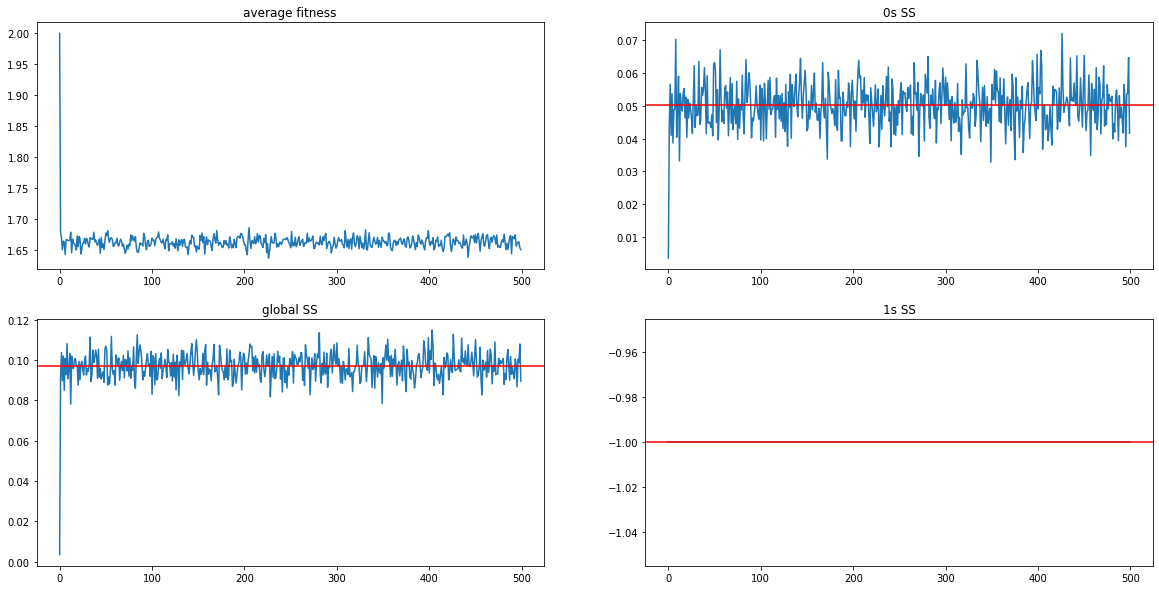

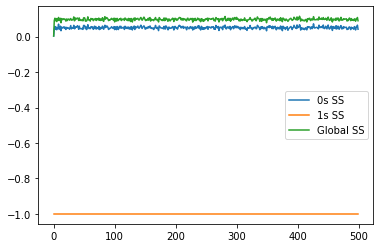

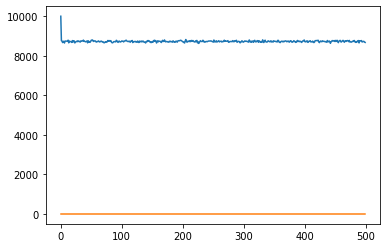

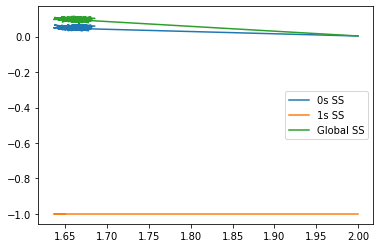

In [51]:
#plot WF results
fig, axs = plt.subplots(2,2,figsize=(20,10))

axs[0][0].plot(aveFitLog0)
axs[0][0].set_title("average fitness")
axs[0][1].plot(selStrLog0)
# print(mean(selStrLog0),stdev(selStrLog0))
axs[0][1].axhline(mean(selStrLog0),color="r")
axs[0][1].set_title("0s SS")


axs[1][0].plot(globalss)
axs[1][0].set_title("global SS")
axs[1][0].axhline(mean(globalss),color="r")

axs[1][1].plot(selStrLog1)
# print(mean(selStrLog1),stdev(selStrLog1))
axs[1][1].axhline(mean(selStrLog1),color="r")
axs[1][1].set_title("1s SS")
plt.show()

plt.plot(selStrLog0,label="0s SS")
plt.plot(selStrLog1,label="1s SS")
plt.plot(globalss,label="Global SS")
# plt.axhline(1)
plt.legend()
# plt.yscale("log")
plt.show()

plt.plot(popsizes0)
plt.plot(popsizes1)
plt.show()

plt.plot(aveFitLog0,selStrLog0,label="0s SS")
plt.plot(aveFitLog0,selStrLog1,label="1s SS")
plt.plot(aveFitLog0,globalss,label="Global SS")
# plt.yscale("log")
plt.legend()
plt.show()
# print("checkSum (1.0)", sum([sum(V) for V in offCountAcc.values()]) / (GENERATIONS*POP_SIZE) )
# meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
# stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

# plt.figure(figsize=(10,5))
# plt.plot(getDriftReference(POP_SIZE,POP_SIZE)[:max(offCountAcc.keys())+1],
#          label="Wright-Fisher Drift Theory",color="k")

# plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

# plt.fill_between(sorted(stdvDict.keys()),
#                  [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  alpha=0.3,color="r",label="99% Confidence interval")
# plt.legend()
# plt.title("")
# plt.xlabel("Parent's Offspring Count")
# plt.ylabel("Fraction of Parents with Count")
# plt.yscale("log")
# plt.show()
